In [112]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
    
sys.path.append('xgboost/wrapper/')
import xgboost
from xgboost import XGBClassifier
    
#input data
train_df=pd.read_json('data/train.json')
# build_df=pd.read_csv("data/train_new.csv")
test_df=pd.read_json('data/final_temp.json')
# train_df["building_id"] = build_df["building_id"]

In [113]:
def feature_engineering(df):
    
    df["created"] = pd.to_datetime(df["created"])
    df["days_since"] = (df["created"].max() - df["created"])
    df["days_since"] = (df["days_since"] / np.timedelta64(1, 'D')).astype(int)
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour
    df["is_night"] = 1*(df["created_hour"] <= 7)
    df["created_weekday"] = df["created"].dt.weekday
    df["is_weekend"] = 1*(df["created_weekday"] > 5)
    
    df["total_rooms"] = df["bedrooms"] + df["bathrooms"]
    df["diff_rooms"] = df['bedrooms'] - df['bathrooms']
    df['price_per_bed'] = df['price']/(df['bedrooms']+1)
    df['price_per_bath'] = df['price']/(df['bathrooms']+1)
    df["price_per_room"] = df['price']/(df['total_rooms']+1)
    
    df['description'] = df['description'].str.replace('<[^<>]+>', ' ')
    df['description'] = df['description'].str.replace('[0-9]+', 'num')
    df['description'] = df['description'].str.lower().replace('[^a-zA-Z0-9]', ' ')
    
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))

    df["num_photos"] = df["photos"].apply(len)
    df["num_photos_per_room"] = df['num_photos'] / df['total_rooms']
    
    df["pos"] = df.longitude.round(3).astype(str) + '_' + df.latitude.round(3).astype(str)
    vals = df['pos'].value_counts()
    dvals = vals.to_dict()
    df["density"] = df['pos'].apply(lambda x: dvals.get(x, vals.min()))
            
    df["logprice"] = np.log(df["price"])

    num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price", "num_features", 
    "num_description_words", "days_since", "created_month", "created_day", "created_hour", "created_weekday", 
    "is_night", "is_weekend", "num_photos", "price_per_bed", "price_per_bath", "total_rooms","diff_rooms",
    "price_per_room", "num_photos_per_room", "logprice", "density", "description", "features"]
    X = df[num_feats]
    return X

train = feature_engineering(df=train_df)
test = feature_engineering(df=test_df)

In [81]:
index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[np.nan]*len(train_df)
b=[np.nan]*len(train_df)
c=[np.nan]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c

train['manager_level_low'] = train_df['manager_level_low']
train['manager_level_medium'] = train_df['manager_level_medium']
train['manager_level_high'] = train_df['manager_level_high']

a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]
for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

test['manager_level_low'] = test_df['manager_level_low']
test['manager_level_medium'] = test_df['manager_level_medium']
test['manager_level_high'] = test_df['manager_level_high']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [82]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            
train['display_address'] = train_df['display_address']         
train['manager_id'] = train_df['manager_id']
train['building_id'] = train_df['building_id']
train['street_address'] = train_df['street_address']

test['display_address'] = test_df['display_address']         
test['manager_id'] = test_df['manager_id']
test['building_id'] = test_df['building_id']
test['street_address'] = test_df['street_address']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [83]:
from math import sin, cos, sqrt, atan2, radians

def get_dist(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

def get_dist_features(df):
    df["cp_dist"] = list(map(lambda lat2, lon2: get_dist(40.783661, -73.96536827, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["jfk_dist"] = list(map(lambda lat2, lon2: get_dist(40.64912697, -73.78692627, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["wsp_dist"] = list(map(lambda lat2, lon2: get_dist(40.73083612, -73.99749041, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["fd_dist"] = list(map(lambda lat2, lon2: get_dist(40.705628, -74.010278, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["ca_dist"] = list(map(lambda lat2, lon2: get_dist(40.849209,-73.888508, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["61_dist"] = list(map(lambda lat2, lon2: get_dist(40.747844,-73.901731, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["aa_dist"] = list(map(lambda lat2, lon2: get_dist(40.678722,-73.951174, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["la_dist"] = list(map(lambda lat2, lon2: get_dist(40.688788,-73.870111, lat2, lon2), 
    df["latitude"], df["longitude"]))
    df["ja_dist"] = list(map(lambda lat2, lon2: get_dist(40.624861,-73.967846, lat2, lon2), 
    df["latitude"], df["longitude"]))
    

    features = ["cp_dist", "jfk_dist", "wsp_dist", "fd_dist", "ca_dist", "61_dist", "aa_dist", "la_dist", "ja_dist"]
    
    return df[features]

dist_features = get_dist_features(train_df)
train = pd.concat([train, dist_features], axis=1)

dist_features_test = get_dist_features(test_df)
test = pd.concat([test, dist_features_test], axis=1)

# test["cp_dist"] = test_df["cp_dist"]
# test["jfk_dist"] = test_df["jfk_dist"]
# test["wsp_dist"] = test_df["wsp_dist"]
# test["fd_dist"] = test_df["fd_dist"]
# test["ca_dist"] = test_df["ca_dist"]
# test["61_dist"] = test_df["61_dist"]
# test["aa_dist"] = test_df["aa_dist"]
# test["la_dist"] = test_df["la_dist"]
# test["ja_dist"] = test_df["ja_dist"]

In [84]:
def get_train_clusters (train_df):
    latlong = train_df.copy () [['latitude', 'longitude']]
    n_cluster = 15
    clf = KMeans(n_clusters=n_cluster)
    clf.fit(latlong)
    train_df['cluster_id'] = clf.labels_
    
    return train_df['cluster_id'], clf

train_clusters, clf = get_train_clusters (train_df)
print(train_clusters.head())

def get_test_clusters (test_df, clf):
    latlong = test_df.copy () [['latitude', 'longitude']]
    testLabels = [clf.predict([x]) for x in test_df.copy()[['latitude','longitude']].values]
    test_df["cluster_id"] = np.asarray(testLabels)
    
    return test_df['cluster_id']

test_clusters = get_test_clusters(test_df, clf)
print(test_clusters.head())

10         0
100004    11
100007     6
100014    11
100026     4
Name: cluster_id, dtype: int32
10000     10
100013     4
100016    10
100020    11
100099     6
Name: cluster_id, dtype: int32


In [85]:
train = pd.concat([train, train_clusters], axis=1)
test = pd.concat([test, test_clusters], axis=1)

In [87]:
def get_count_features(df):
    m_count = df.groupby(["manager_id"]).count().iloc[:, 1].to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "num_listing_manager"] = m_count[df.loc[df.index[i], "manager_id"]]
    
    b_count = df.groupby(["building_id"]).count().iloc[:, 1].to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "num_listing_build"] = b_count[df.loc[df.index[i], "building_id"]]
        
    sa_count = df.groupby(["street_address"]).count().iloc[:, 1].to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "num_listing_sa"] = sa_count[df.loc[df.index[i], "street_address"]]
        
    da_count = df.groupby(["display_address"]).count().iloc[:, 1].to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "num_listing_da"] = da_count[df.loc[df.index[i], "display_address"]]
    
    p_med_man = df.groupby(["manager_id"]).price.median().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "median_price_g_manager"] = p_med_man[df.loc[df.index[i], "manager_id"]]
    
    p_med_bui = df.groupby(["building_id"]).price.median().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "median_price_g_build"] = p_med_bui[df.loc[df.index[i], "building_id"]]
        
    p_std_man = df.groupby(["manager_id"]).price.std().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "std_price_g_manager"] = p_std_man[df.loc[df.index[i], "manager_id"]]
    
    p_std_bui = df.groupby(["building_id"]).price.std().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "std_price_g_build"] = p_std_bui[df.loc[df.index[i], "building_id"]]
        
    p_std_clus = df.groupby(["cluster_id"]).price.std().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "std_price_g_clus"] = p_std_clus[df.loc[df.index[i], "cluster_id"]]
        
    p_med_clus = df.groupby(["cluster_id"]).price.median().to_dict()
    for i in range(df.shape[0]):
        df.loc[df.index[i], "med_price_g_clus"] = p_med_clus[df.loc[df.index[i], "cluster_id"]]
        
    features=["num_listing_manager", "num_listing_build", "num_listing_sa", "num_listing_da", 
              "median_price_g_manager", "median_price_g_build", "std_price_g_manager", "std_price_g_build",
             "med_price_g_clus", "std_price_g_clus"]
    
    return df[features]

df_count = get_count_features(df=train_df)
df_test_count = get_count_features(df=test_df)

In [88]:
train = pd.concat([train, df_count], axis=1)
test = pd.concat([test, df_test_count], axis=1)

In [ ]:
# train = pd.read_csv("data/all_feat.csv", index_col='index')
train["listing_id"] = train_df["listing_id"]
test["listing_id"] = test_df["listing_id"]

In [ ]:
print(train.iloc[1])
# print(test.shape)

In [89]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())

10                                                         
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100014                                                     
100026    Cats_Allowed Dogs_Allowed Elevator Laundry_In_...
Name: features, dtype: object


In [90]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

In [91]:
tfidf_d = TfidfVectorizer(stop_words='english', max_features=100, ngram_range=(1,2))
tr_desc_sparse = tfidf_d.fit_transform(train_df["description"])
te_desc_sparse = tfidf_d.transform(test_df["description"])

In [96]:
xtrain = sparse.hstack([train_df[features_to_use], tr_desc_sparse]).tocsr()
xtest = sparse.hstack([test_df[features_to_use], te_desc_sparse]).tocsr()

In [95]:
# features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price", "num_features", 
#     "num_description_words", "days_since", "created_month", "created_day", "created_hour", "created_weekday", 
#     "is_night", "is_weekend", "num_photos", "price_per_bed", "price_per_bath", "total_rooms","diff_rooms",
#     "price_per_room", "num_photos_per_room", "logprice",
#     "density", "num_listing_manager", "num_listing_build", 
#     "num_listing_sa", "num_listing_da", "median_price_g_manager", "median_price_g_build", "std_price_g_manager", 
#     "std_price_g_build", "manager_level_low", "manager_level_medium", "manager_level_high", 
#     "display_address", "manager_id", "building_id", "street_address", 
#     "cp_dist", "jfk_dist", "wsp_dist", "fd_dist", "ca_dist", "61_dist", "aa_dist", "la_dist", "ja_dist", "cluster_id",
#     "median_price_g_clus", "std_price_g_clus"]

features_to_use = ["bathrooms", "bedrooms", "price", "num_features", 
    "num_description_words", "days_since", "created_month", "created_day", "created_hour", "created_weekday", 
    "is_night", "is_weekend", "num_photos", "price_per_bed", "price_per_bath", "total_rooms","diff_rooms",
    "price_per_room", "num_photos_per_room", "logprice",
    "density", "num_listing_manager", "num_listing_build", 
    "num_listing_sa", "num_listing_da", "median_price_g_manager", "median_price_g_build", "std_price_g_manager", 
    "std_price_g_build", "manager_level_low", "manager_level_medium", "manager_level_high", 
    "display_address", "manager_id", "building_id", "street_address", 
    "cp_dist", "jfk_dist", "wsp_dist", "fd_dist", "ca_dist", "61_dist", "aa_dist", "la_dist", "ja_dist", "cluster_id",
    "med_price_g_clus", "std_price_g_clus"]

# features_to_use = ["bathrooms", "bedrooms", "price", "num_features", 
#     "num_description_words", "created_month", "created_day", "created_hour", "created_weekday", 
#     "is_night", "is_weekend", "num_photos", "price_per_bed", "price_per_bath", "total_rooms","diff_rooms",
#     "price_per_room", "num_photos_per_room", "logprice",
#     "density", "num_listing_manager", 
#     "num_listing_sa", "num_listing_da", "median_price_g_manager", "median_price_g_build", "std_price_g_manager", 
#     "std_price_g_build", "manager_level_low", "manager_level_medium", "manager_level_high", 
#     "display_address", "manager_id", "building_id", "street_address", 
#     "cp_dist", "jfk_dist", "wsp_dist", "fd_dist", "ca_dist", "61_dist", "aa_dist", "la_dist", "ja_dist"]

print(len(features_to_use))


48


In [97]:
train_X = sparse.hstack([xtrain, tr_sparse]).tocsr()
test_X = sparse.hstack([xtest, te_sparse]).tocsr()

In [98]:
features_to_use.extend(tfidf.get_feature_names())
features_to_use.extend(tfidf_d.get_feature_names())
len(features_to_use)

648

In [99]:
target_num_map = {'high':0, 'low':1, 'medium':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
test_y = np.array(test_df['interest_level'].apply(lambda x: target_num_map[x]))

In [ ]:
# def runXGB1(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
#     param = {}
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.03
#     param['max_depth'] = 6
#     param['silent'] = 1
#     param['num_class'] = 3
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 3
#     param['subsample'] = 0.7
#     param['colsample_bytree'] = 0.7
#     param['seed'] = seed_val
#     num_rounds = num_rounds

#     plst = list(param.items())
#     xgtrain = xgboost.DMatrix(train_X, label=train_y, feature_names=features_to_use)

#     if test_y is not None:
#         xgtest = xgboost.DMatrix(test_X, label=test_y, feature_names=features_to_use)
#         watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
#         model = XGBClassifier.fit(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
#     else:
#         xgtest = xgboost.DMatrix(test_X)
#         model = XGBClassifier.fit(plst, xgtrain, num_rounds)

#     pred_test_y = model.predict(xgtest)
#     return pred_test_y, model

# def runXGB2(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
#     param = {}
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.05
#     param['max_depth'] = 10
#     param['silent'] = 1
#     param['num_class'] = 3
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 5
#     param['subsample'] = 0.7
#     param['colsample_bytree'] = 0.7
#     param['colsample_bylevel'] = 0.7
#     param['lambda'] = 2
#     param['alpha'] = 2
#     param['gamma'] = 1
#     param['seed'] = seed_val
#     num_rounds = num_rounds

#     plst = list(param.items())
#     xgtrain = xgboost.DMatrix(train_X, label=train_y, feature_names=features_to_use)

#     if test_y is not None:
#         xgtest = xgboost.DMatrix(test_X, label=test_y, feature_names=features_to_use)
#         watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
#         model = XGBClassifier.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
#     else:
#         xgtest = xgboost.DMatrix(test_X)
#         model = XGBClassifier.train(plst, xgtrain, num_rounds)

#     pred_test_y = model.predict(xgtest)
#     return pred_test_y, model

In [118]:
# def runXGB1(X_train, y_train, X_test, y_test):
#     model = XGBClassifier(max_depth=6, learning_rate=0.03, n_estimators=700, min_child_weight=3, 
#                           subsample=0.7, colsample_bytree=0.7, n_jobs=-1, silent=0, objective='multi:softprob')
    
#     model.fit(X_train, y_train)
#     y_train_pred = model.predict_proba(X_train)
    
#     print("Log loss on train: %f"%(log_loss(y_train, y_train_pred)))
    
#     y_test_pred = model.predict_proba(X_test)
    
#     print("Log loss on train: %f"%(log_loss(y_test, y_test_pred)))
    
#     return y_test_pred, model
    
def runXGB2(X_train, y_train, X_test, y_test):
    model = XGBClassifier(max_depth=4, learning_rate=0.04, n_estimators=800, gamma=1, min_child_weight=5, 
                          subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7, reg_alpha=3,
                          reg_lambda=3, n_jobs=-1, silent=0, objective='multi:softprob')
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)
    
    print("Log loss on train: %f"%(log_loss(y_train, y_train_pred)))
    
    y_test_pred = model.predict_proba(X_test)
    
    print("Log loss on train: %f"%(log_loss(y_test, y_test_pred)))
    
    return y_test_pred, model

# def runRF(X_train, y_train, X_test, y_test):
#     model = RandomForestClassifier(n_estimators=500, max_depth=20, max_features='auto'
#         , min_samples_leaf=70, min_samples_split=50, n_jobs=-1)
#     print("\nRandom Forest: Training...\n")
#     model.fit(X_train, y_train)

#     y_train_pred = model.predict_proba(X_train)
#     print("Random Forest: Log loss on training set: %f" %log_loss(y_train, y_train_pred))

#     y_test_pred = model.predict_proba(X_test)
        
#     print("\nRandom Forest: Log loss on validation set: %f" %log_loss(y_test, y_test_pred))


In [ ]:
print(train_X[0])

In [119]:
#Use voting classifier
# pred1, model1 = runXGB1(train_X, train_y, test_X, test_y)
# pred1, model1 = runRF(train_X, train_y, test_X, test_y)
pred2, model2 = runXGB2(train_X, train_y, test_X, test_y)

[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:01:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:58] /work

[23:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:10] /work

[23:02:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:21] /work

[23:02:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:02:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:02:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:02:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:02:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:02:31] /work

[23:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:02:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:02:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:02:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:02:43] /work

[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:02:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:02:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:02:55] /work

[23:03:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[23:03:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:03:06] /work

[23:03:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:03:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:15] /work

[23:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[23:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:03:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[23:03:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:03:25] /work

[23:03:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:03:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:03:34] /work

[23:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:03:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[23:03:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:44] /work

[23:03:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:03:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[23:03:53] /work

[23:04:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:04:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:04:04] /work

[23:04:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:04:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:04:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[23:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:15] /work

[23:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:04:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:28] /work

[23:04:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[23:04:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[23:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[23:04:39] /wor

[23:04:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:04:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:04:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[23:04:51] /work

[23:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[23:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:05:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:05:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:05:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:05:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:05:02] /work

[23:05:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:05:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:05:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:05:14] /work

[23:05:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:05:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:05:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[23:05:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:05:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:05:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:05:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:05:25] /work

[23:05:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:05:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:05:37] /work

[23:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:05:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:05:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:05:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[23:05:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:05:48] /wor

[23:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[23:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:05:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:06:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:06:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:06:00] /wor

[23:06:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:06:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:06:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:06:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:06:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[23:06:11] /work

[23:06:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[23:06:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:23] /work

[23:06:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:06:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:06:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:06:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[23:06:34] /work

[23:06:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:06:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[23:06:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:06:45] /work

[23:06:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:06:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:06:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[23:06:57] /wor

[23:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[23:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[23:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:07:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:07:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[23:07:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:07:08] /work

[23:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[23:07:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[23:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:07:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:07:19] /work

[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[23:07:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[23:07:31] /work

[23:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:07:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:07:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[23:07:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:07:42] /work

[23:07:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:07:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[23:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[23:07:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:07:53] /work

[23:08:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:08:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[23:08:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:08:06] /work

[23:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[23:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[23:08:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[23:08:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[23:08:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:08:17] /work

[23:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[23:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[23:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[23:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[23:08:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[23:08:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[23:08:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[23:08:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[23:08:28] /wor

In [ ]:
# model = VotingClassifier(estimators=[('rf', model1), ('xgb2', model2)], voting='soft', n_jobs=-1)
# model.fit(train_X,train_y)
# print("done")
# y_pred = model.predict_proba(test_X)
# print(log_loss(test_y, y_pred))

In [ ]:
# def Stacking(model,train,y,test,n_fold):
#     folds=StratifiedKFold(n_splits=n_fold,random_state=1)
#     test_pred=np.empty((test.shape[0],1),float)
#     train_pred=np.empty((0,1),float)
    
#     for train_indices,val_indices in folds.split(train,y.values):
#         x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
#         y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

#         model.fit(X=x_train,y=y_train)
#         train_pred=np.append(train_pred,model.predict(x_val))
        
#     model.fit(train, y)
#     test_pred=model.predict(test)
#     return test_pred.reshape(-1,1),train_pred

# model1 = tree.DecisionTreeClassifier(random_state=1)
# test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=x_train,test=x_test,y=y_train)
# train_pred1=pd.DataFrame(train_pred1)
# test_pred1=pd.DataFrame(test_pred1)

# model2 = LogisticRegression()
# test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)
# train_pred2=pd.DataFrame(train_pred2)
# test_pred2=pd.DataFrame(test_pred2)

# df = pd.concat([train_pred1, train_pred2], axis=1)
# df_test = pd.concat([test_pred1, test_pred2], axis=1)

# model = LogisticRegression(random_state=1)
# model.fit(df,y_train)
# model.score(df_test, y_test)

In [ ]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

In [ ]:
# preds, model = runXGB2(train_X, train_y, test_X, test_y, num_rounds=1500)

In [ ]:
print(log_loss(test_y, preds))

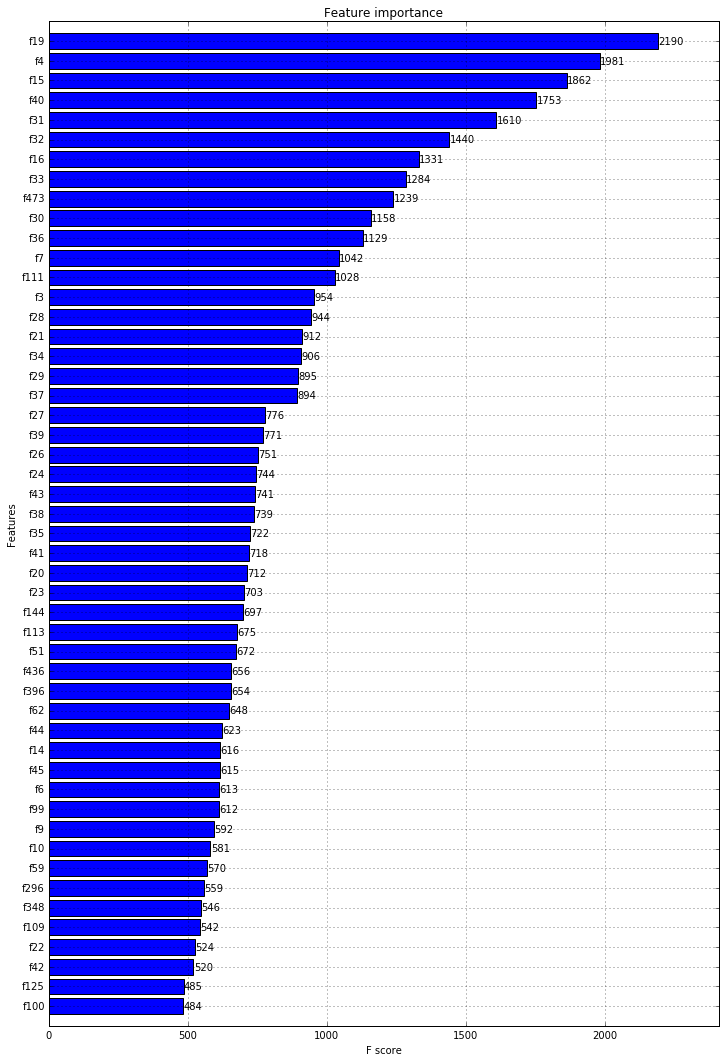

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,18))
fig = xgboost.plot_importance(model2, max_num_features=50, height=0.8, ax=ax)
plt.show()
# xgb.plot.importance(importance_matrix = importance)

[(0, 'bathrooms'), (1, 'bedrooms'), (2, 'latitude'), (3, 'longitude'), (4, 'price'), (5, 'num_features'), (6, 'num_description_words'), (7, 'days_since'), (8, 'created_month'), (9, 'created_day'), (10, 'created_hour'), (11, 'created_weekday'), (12, 'is_night'), (13, 'is_weekend'), (14, 'num_photos'), (15, 'price_per_bed'), (16, 'price_per_bath'), (17, 'total_rooms'), (18, 'diff_rooms'), (19, 'price_per_room'), (20, 'num_photos_per_room'), (21, 'logprice'), (22, 'density'), (23, 'num_listing_manager'), (24, 'num_listing_build'), (25, 'num_listing_sa'), (26, 'num_listing_da'), (27, 'median_price_g_manager'), (28, 'median_price_g_build'), (29, 'std_price_g_manager'), (30, 'std_price_g_build'), (31, 'manager_level_low'), (32, 'manager_level_medium'), (33, 'manager_level_high'), (34, 'display_address'), (35, 'manager_id'), (36, 'building_id'), (37, 'street_address'), (38, 'cp_dist'), (39, 'jfk_dist'), (40, 'wsp_dist'), (41, 'fd_dist'), (42, 'ca_dist'), (43, '61_dist'), (44, 'aa_dist'), (45,

In [77]:
mapper = {'f{0}'.format(i): v for i, v in list(enumerate(features_to_use))}
print(len(mapper))
mapped = {mapper[k]: v for k, v in model2.get_booster().get_fscore()}
xgboost.plot_importance(mapped, color='red')

648


ValueError: too many values to unpack (expected 2)

In [78]:
len(model2.get_booster().get_fscore())

205

In [72]:
feat_imp = model2.feature_importances_

zero_ind = []

for i in range(len(feat_imp)):
    if(feat_imp[i]==0):
        zero_ind.append(i)
        
print(zero_ind)

[148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 347, 349, 350, 352, 353, 354, 355, 356, 357, 358, 359, 361,

In [69]:
a = enumerate(features_to_use)
b=[]
for (i, feat) in list(a):
    if(i in zero_ind):
        b.append(feat)
        
print(b)

['_ss_eat', '_ss_kitchen_', '_steps_to_central_park', '_steps_to_l_train_', '_steps_to_the_park', '_steps_to_the_park_', '_stunning_renovations_', '_sunny', '_the_perfect_share_', '_tons_of_sunlight_', '_underpriced', '_underpriced_', '_underpriced_no_fee_', '_unique_renovations_', '_uptown', '_w50s_', '_w70s_winner', '_walls_of_windows_', '_washer', '_windows_all_around_', 'a_full_service_luxury_highrise', 'actual_apt', 'actual_photos', 'air_conditioning', 'all_utilities_included', 'art_fitness_center', 'assigned', 'attended_lobby', 'backyard', 'balconies_in_both_bedrooms', 'balcony', 'basement_storage', 'basketball_court', 'bike_room', 'bike_storage', 'billiards_lounge', 'billiards_room', 'brand_new', 'breakfast_bar', 'bright', 'bright_', 'brownstone', 'building', 'built', 'burning_fireplace', 'business_center', 'cable', 'cable_ready', 'cats_allowed', 'central_a', 'central_ac', 'central_air', 'chefs_kitchen', 'children', 'childrens_playroom', 'cinema_room', 'city_view', 'close_to_sub

In [111]:
model = XGBClassifier()
print(model.get_params())
# max_depth=6, learning_rate=0.03, n_estimators=700, gamma=1, min_child_weight=5, 
#                           subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7, reg_alpha=2,
#                           reg_lambda=2,
grid = {'max_depth' : [2,3,4,5,6,7,8,9,10],
        'learning_rate' : [0.03],
        'n_estimators' : [800],
        'gamma' : [0.5, 1, 2, 3, 4], 
        'min_child_weight' : [3,4,5,6,7,8,9,10],
        'reg_alpha' : [0.5, 1, 1.5, 2, 2.5, 5],
        'reg_lambda' : [0.5, 1, 1.5, 2, 2.5, 5],
        'subsample' : [0.6],
        'colsample_bytree' : [0.6],
        'colsample_bylevel' :[0.6]
        }

kFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
randomSearch = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=100, 
                                  verbose=5, scoring="neg_log_loss", n_jobs=-1, cv=kFold)

rs_result = randomSearch.fit(train_X, train_y)

print("Best: %f using %s" % (rs_result.best_score_, rs_result.best_params_))
means = rs_result.cv_results_['mean_test_score']
stds = rs_result.cv_results_['std_test_score']
params = rs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'base_score': 0.5, 'silent': True, 'subsample': 1, 'nthread': None, 'n_estimators': 100, 'scale_pos_weight': 1, 'max_depth': 3, 'gamma': 0, 'learning_rate': 0.1, 'colsample_bylevel': 1, 'min_child_weight': 1, 'seed': None, 'max_delta_step': 0, 'reg_alpha': 0, 'objective': 'binary:logistic', 'booster': 'gbtree', 'colsample_bytree': 1, 'reg_lambda': 1, 'n_jobs': 1, 'missing': None, 'random_state': 0}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2.5, gamma=2 
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2.5, gamma=2 
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2.5, gamma=2 
[CV] learnin

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 25.1min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=1.5, gamma=4, score=-0.5426831922301067, total= 6.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=2, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=0.5, gamma=1, score=-0.5488488143125495, total=10.3min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=1 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=1, score=-0.5504656681719583, total= 3.4min
[CV]

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=0.5, score=-0.5437299889200752, total= 4.5min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=2, gamma=4, score=-0.5467704537263007, total= 5.6min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=2.5, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=2, gamma=4, score=-0.543039377270616, total= 5.6min
[CV] 

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=4, score=-0.5465068955459198, total= 6.5min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2.5, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=4, score=-0.5436462638116917, total= 6.5min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2.5, gamma=4, score=-0.5404848127012927, total= 7.6mi

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 150.4min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=3, score=-0.5506613351433702, total= 3.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=1, gamma=1 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=2.5, gamma=3, score=-0.5400257705753178, total= 9.3min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=5, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=1, gamma=1, score=-0.5437834388719258, total= 5.8min
[CV] l

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=2, score=-0.5442822268428807, total= 5.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=2.5, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=2, score=-0.5410947957632527, total= 5.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=1.5, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=2.5, gamma=0.5, score=-0.5400362554878292, total= 5.8

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=1, gamma=1, score=-0.5401342054183547, total= 5.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=1, gamma=1 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=8, reg_lambda=2, gamma=3, score=-0.5438157408369172, total= 9.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=2.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=8, reg_lambda=2, gamma=3, score=-0.5402475029066549, total= 9.8min
[CV] lea

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=4, score=-0.5542986758345593, total= 4.0min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=10, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=10, reg_lambda=5, gamma=2, score=-0.5469855834128982, total=13.1min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=2.5, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=4, score=-0.5590217571535074, total= 4.1min
[C

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=1, gamma=0.5, score=-0.5444102508285267, total= 7.1min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=2, score=-0.5438056792243771, total= 4.6min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=0.5, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=2, score=-0.5477681925905777, total= 4.6min
[CV]

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 330.8min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=2.5, gamma=3, score=-0.5399022990106773, total= 8.1min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=2.5, gamma=3 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=0.5, gamma=0.5, score=-0.5543593959663488, total=10.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2.5, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=0.5, gamma=0.5, score=-0.5506237449606484, tota

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=2, reg_lambda=1.5, gamma=2, score=-0.5655849774830779, total= 2.4min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=2, reg_lambda=1.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=8, reg_lambda=2.5, gamma=0.5, score=-0.5473122593314427, total= 8.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=2, gamma=4 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=2, reg_lambda=1.5, gamma=2, score=-0.5620465003996047, total= 2.3min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=2, gamma=1, score=-0.5411283689641045, total= 7.1min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=1 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=1, score=-0.5497876433892722, total= 3.4min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=3 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=2, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=4, reg_lambda=1.5, gamma=2, score=-0.5449342719529355, total= 4.6min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=5, gamma=4, score=-0.5519221991369189, total= 6.7min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=10, reg_lambda=1.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=5, gamma=4, score=-0.548840479978692, total= 6.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=10, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=6, reg_lambda=5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=6, reg_alpha=1.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=10, reg_lambda=1.5, gamma=2, score=-0.5428559671614225, total=13.5min
[C

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=0.5, gamma=1, score=-0.5450699020843641, total= 9.9min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=8, reg_lambda=2.5, gamma=0.5 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=7, reg_lambda=0.5, gamma=1, score=-0.5421880624180596, total= 9.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=9, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=2.5, gamma=3 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=7, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=8, reg_lambda=2.5, gamma=0.5, score=-0.5417890800368895, total=10.9

[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=0.5, score=-0.5443908314699377, total= 5.8min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=5, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=0.5, gamma=1 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=8, reg_alpha=5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=5, reg_lambda=0.5, gamma=0.5, score=-0.5419377700089691, total= 5.7min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=10, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=2, reg_lambda=0.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=10, reg_alpha=1, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=2, reg_lambda=0.5, gamma=2, score=-0.5619772301134676, total= 2.3

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 581.3min


[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=2, gamma=2, score=-0.5542932116783018, total= 3.4min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=4, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=2, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=1, gamma=4, score=-0.540517821624818, total=10.5min
[CV] learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=0.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=3, reg_lambda=1.5, gamma=2 
[CV]  learning_rate=0.03, colsample_bylevel=0.6, min_child_weight=3, reg_alpha=2.5, subsample=0.6, colsample_bytree=0.6, n_estimators=800, max_depth=9, reg_lambda=1, gamma=4, score=-0.5450630922701732, total=10.7min
[CV

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 646.7min finished


Best: -0.540799 using {'learning_rate': 0.03, 'colsample_bylevel': 0.6, 'min_child_weight': 3, 'reg_alpha': 1.5, 'n_estimators': 800, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 7, 'reg_lambda': 2.5, 'gamma': 3}
-0.541499 (0.001841) with: {'learning_rate': 0.03, 'colsample_bylevel': 0.6, 'min_child_weight': 9, 'reg_alpha': 2, 'n_estimators': 800, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 6, 'reg_lambda': 2.5, 'gamma': 2}
-0.542034 (0.001592) with: {'learning_rate': 0.03, 'colsample_bylevel': 0.6, 'min_child_weight': 3, 'reg_alpha': 2, 'n_estimators': 800, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 8, 'reg_lambda': 1, 'gamma': 4}
-0.550253 (0.001503) with: {'learning_rate': 0.03, 'colsample_bylevel': 0.6, 'min_child_weight': 9, 'reg_alpha': 1, 'n_estimators': 800, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 9, 'reg_lambda': 0.5, 'gamma': 1}
-0.543112 (0.001704) with: {'learning_rate': 0.03, 'colsample_bylevel': 0.6, 'min_child_weight': 